## My--LightGCN

### 1. import  basic packages

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn.functional as F

from torch_geometric.data import download_url, extract_zip
from torch_geometric.utils.negative_sampling import structured_negative_sampling
from tqdm.notebook import tqdm
import time 

In [2]:
print(torch.__version__)

2.1.0+cu121


### 2. load Dataset

#### 2-1 download dataset

In [3]:
url_path = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(path=download_url(url=url_path, folder='.'), folder='.')

Using existing file ml-latest-small.zip
Extracting .\ml-latest-small.zip


In [4]:
movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

In [5]:
rating_df = pd.read_csv(rating_path)
print(rating_df.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [6]:
# label numeric
# machine learning models only take numerical data
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

In [7]:
print(np.array(rating_df.userId))

[  1   1   1 ... 610 610 610]


In [8]:
rating_df.userId = lbl_user.fit_transform(np.array(rating_df.userId))
rating_df.movieId = lbl_movie.fit_transform(np.array(rating_df.movieId))

In [9]:
print(f'rating_df.userId.max()={rating_df.userId.max()}')   # users 0 ~ 609
print(f'rating_df.movieId.max()={rating_df.movieId.max()}') # movies 0 ~ 9723

rating_df.userId.max()=609
rating_df.movieId.max()=9723


#### 2-2 load edges between users and movies for structured negative sampling

In [10]:
def load_edge_csv(rating_df, src_index_col, det_index_col, link_index_col, rating_threshold=3.5):
    """
    load COO matrix between users and items (COO format)
    :param src_index_col: column name of users
    :param det_index_col: column name of items
    :param link_index_col: user item intersection
    :param rating_threshold: filter ranks lower than 3.5
    :return edge_index: the position of each record, user_id and item_id respectively
    :return edge_values: the value of each record
    """
    
    src = [user_id for user_id in rating_df['userId']]
    det = [movie_id for movie_id in rating_df['movieId']]
    link_vals = rating_df[link_index_col].values  # extract all rating from rating_df -> tensor
    
    # edge_attr is a bool tensor, each element is >0 when the rating > rating_threshold counterpart
    # view(-1, 1) -> len(
    edge_attr = torch.from_numpy(link_vals).view(-1, 1).to(torch.long) >= rating_threshold  # len(edge_attr) == len(link_vals)
    edge_index = [[], []]
    edge_values = []
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(det[i])
            edge_values.append(link_vals[i])
            
    return edge_index, edge_values 

In [11]:
# all records in edge_index are valid records! 
edge_index, edge_values = load_edge_csv(rating_df,
                           src_index_col='userId',
                           det_index_col='movieId',
                           link_index_col='rating',
                           rating_threshold=3.5
                           )

print(f'num_intersections={len(edge_index[0])}')  # 48580 valid rating records

num_intersections=48580


In [12]:
edge_index = np.array(edge_index)  # list -> ndarray
print(edge_index.dtype)   # 48580 valid intersections -> int 32
edge_values = np.array(edge_values)
print(f'edge_values.size={len(edge_values)}')

int32
edge_values.size=48580


In [13]:
# unique() in pd: remove all duplicates
num_movies = len(rating_df['movieId'].unique())  # 9724 movies
num_users = len(rating_df['userId'].unique())   # 610 users

In [14]:
print(f'num_users={num_users}\tnum_movies={num_movies}')

num_users=610	num_movies=9724


In [15]:
num_intersections = edge_index.shape[1]

#### 2-3 split training_data and validation_data and test_data

just need to split the random_indices train: test = 7:3

In [16]:
all_indices = [i for i in range(num_intersections)]

train_indices, test_indices = train_test_split(all_indices,
                                               test_size=0.4,
                                               shuffle=True,
                                               random_state=16)

# not data not position but index in all records
train_index = edge_index[:, train_indices]
test_index = edge_index[:, test_indices]

In [17]:
# only torch.tensor can fetch the given list index values, while only traditional slicing operation is available in python list
train_values = edge_values[train_indices]
test_values = edge_values[test_indices]

In [18]:
print(len(train_values))
print(len(test_values))

29148
19432


In [19]:
print(train_index[0][1])
print(train_index[1][1])
print(train_values[1])

56
2391
4.0


#### 2-4 adj_matrix building

In [20]:
def adjacency_mat(tmp_edge_index, tmp_edge_values):
    """
    convert COO form to adjacency matrix, in train_data, val_data and test_data respectively
    then convert to coo form to save internal storage
    :param tmp_edge_index: train_index / valid_index / test_index
    :param tmp_edge_values: rating records in training set / valid set / test set
    :return: tmp_adj: a scipy sparse matrix before normalization `DAD`
    :return: adj_matrix: a torch.sparse tensor after normalization
    """
    users_ndarray, items_ndarray = np.split(tmp_edge_index, indices_or_sections=2, axis=0)
    users_ndarray = users_ndarray.flatten()  # 2 axis -> 1 axis
    items_ndarray = items_ndarray.flatten()
    ratings_ndarray = tmp_edge_values
    n_nodes = num_users + num_movies
    
    # a scipy sparse matrix
    tmp_adj = sp.csr_matrix((ratings_ndarray, (users_ndarray, items_ndarray + num_users)), shape=(n_nodes, n_nodes))
    adj_mat = tmp_adj + tmp_adj.T
    
    # d -> [1. / sqrt(nu \ ni)]
    row_sum = np.array(adj_mat.sum(1))
    d_inv = np.power(row_sum, -0.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat_inv = sp.dia_array((d_inv, 0), shape=(n_nodes, n_nodes))  # a scipy sparse matrix
     
    return tmp_adj, d_mat_inv

In [21]:
train_adj, train_d = adjacency_mat(train_index, train_values)
test_adj, test_d = adjacency_mat(test_index, test_values)

C:\Users\刘睿仪\AppData\Local\Temp\ipykernel_26052\1612758821.py:22: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(row_sum, -0.5).flatten()


In [22]:
print(train_d.toarray()[824][824])

0.5


#### 2-5 normal matrix for train data and test data

In [23]:
train_array = train_adj.toarray()[:num_users, num_users: ]  # transfer to common np matrix
test_array = test_adj.toarray()[:num_users, num_users: ]

In [24]:
print(train_array[:, 1938].nonzero())
print(test_array[:, 1938].nonzero())

(array([ 16,  17,  18,  23,  27,  41,  44,  48,  51,  61,  65,  66,  67,
        68,  75,  78,  79,  81,  85,  95,  96, 102, 107, 109, 118, 121,
       131, 136, 139, 151, 159, 164, 165, 177, 181, 186, 188, 195, 197,
       199, 201, 203, 208, 210, 218, 219, 226, 227, 230, 231, 232, 233,
       238, 243, 245, 247, 248, 253, 257, 260, 262, 263, 267, 271, 273,
       274, 278, 281, 285, 291, 295, 297, 302, 308, 315, 318, 321, 333,
       343, 350, 353, 355, 361, 368, 369, 380, 386, 389, 392, 398, 399,
       404, 406, 419, 429, 444, 451, 452, 458, 459, 463, 464, 465, 473,
       476, 488, 489, 492, 493, 502, 510, 513, 519, 521, 527, 533, 536,
       539, 547, 548, 549, 550, 551, 553, 559, 560, 561, 569, 572, 579,
       589, 590, 595, 598, 605, 609], dtype=int64),)
(array([  0,  12,  14,  20,  24,  29,  32,  38,  47,  56,  63,  71,  76,
        77,  90,  94, 104, 105, 111, 122, 124, 128, 134, 143, 168, 196,
       198, 207, 209, 221, 225, 236, 240, 250, 255, 264, 265, 266, 299,
       30

### 3. model -- lightGCN

__replenishment__:

1.`softplus` $$ f(x) = ln(1 + e^x)$$

The derivative of `softplus` function is `sigmoid` function

2.`BPR loss`:

$$
L = - \sum_{u=1}^{M} \sum_{i\in N_u} (\sum_{j \notin N_u} ln{\sigma (e_{u}^T e_i - e_{u}^T e_j)) + \lambda{||E||}^2
$$

because I dont' know how to compare a variant that adds normalization to graph Laplacian
    

#### 3-1 build my dataset

not authenticate dataset, no get_item usage

In [25]:
class MyDataset(Dataset):
    def __init__(self, num_users, num_items, sparse_adj_init, d, edge_index, is_training, batch_size=2048):  
        super().__init__()
        self.is_training = is_training
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.num_users = torch.tensor(data=num_users).to(self.device)
        self.num_items = torch.tensor(data=num_items).to(self.device)
        self.batch_size = torch.tensor(data=batch_size).to('cpu')
        
        self.adj_init = sparse_adj_init  # train_adj / valid_adj / test_adj sp sparse matrix
        self.d = d  # train_d / valid_d / test_d the row_sum sp sparse diag matrix
        self.edge_index = torch.tensor(data=edge_index)
    
    def __len__(self):
        return len(self.num_users)
        

In [26]:
training_dataset = MyDataset(num_users, num_movies, train_adj, train_d, train_index, is_training=1)

In [27]:
print(training_dataset.edge_index)
print(train_index)

tensor([[ 351,   56,  199,  ...,   31,  609,  508],
        [8237, 2391, 4421,  ...,  606, 6930, 7841]], dtype=torch.int32)
[[ 351   56  199 ...   31  609  508]
 [8237 2391 4421 ...  606 6930 7841]]


In [28]:
print(len(train_index[0]))

29148


#### 3-2 model design

In [29]:
class LightGCN(nn.Module):
    def __init__(self, dataset, embedding_size=64, embedding_layers=3):
        super().__init__()
        """
        nn.parameters can not be double 
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dataset = dataset  # the class MyDataset
        
        self.num_users = dataset.num_users.to(self.device)
        self.num_items = dataset.num_items.to(self.device)
        self.batch_size = dataset.batch_size  #  structured negative sampling
        self.adj = dataset.adj_init
        self.adj_init = dataset.adj_init
        self.d = dataset.d  # sp sparse diag matrix on cpu
        self.edge_index = dataset.edge_index
        
        self.embedding_size = torch.tensor(data=embedding_size, device=self.device)
        self.embedding_layers = torch.tensor(data=embedding_layers, device=self.device)
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=embedding_size).to(self.device)  # users_emb 
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=embedding_size).to(self.device)  # items_emb 
        self.emb_final = torch.empty(size=(self.num_users + self.num_items, self.embedding_size), device=self.device)
        nn.init.normal_(tensor=self.users_emb.weight, std=0.1) # init weight for embedding layers
        nn.init.normal_(tensor=self.items_emb.weight, std=0.1)  
    
    
    def compute_A(self):  
        # every embedding layer to update A
        norm_mat_tmp = self.d.dot(self.adj)
        self.adj = norm_mat_tmp.dot(self.d)
        
        adj_mat_coo = sp.csr_matrix.tocoo(self.adj)
        values = adj_mat_coo.data
        indices = np.vstack((adj_mat_coo.row, adj_mat_coo.col))  # sp coo matrix only has data / col / row, not indices
        v = torch.FloatTensor(values)
        i = torch.LongTensor(indices)
        coo_shape = adj_mat_coo.shape 
        adj_matrix = torch.sparse_coo_tensor(indices=i, values=v, size=coo_shape, device=self.device)  # torch_sparse coo tensor to save CUDA memory

        return adj_matrix
    
    
    def lgc_pred(self):
        tmp_emb = torch.cat(tensors=(self.users_emb.weight, self.items_emb.weight), dim=0).to(self.device)  # cat on dim 0, dim 1 stays the same
        users_emb_init, items_emb_init = self.users_emb.weight, self.items_emb.weight  
        embs = [tmp_emb]
        
        """convolution, just related to the embedding parameters in init layer"""
        for i in range(self.embedding_layers):
            if i == 0:
                self.adj = self.adj_init  # in my updated version, to avoid the adj matrix in accumulated multiplication
            A = self.compute_A()
            tmp_emb = torch.sparse.mm(A, tmp_emb).to(self.device)  # (m + n, num_embedding)
            embs.append(tmp_emb)
        
        """# aggregate multiple layers to alleviate the over_fit problem"""
        embs = torch.stack(embs, dim=1)
        self.emb_final = torch.mean(embs, dim=1)
        users_emb_final, items_emb_final = torch.split(tensor=self.emb_final, split_size_or_sections=[self.num_users, self.num_items])

        return users_emb_init, items_emb_init, users_emb_final, items_emb_final
    
    
    def pred(self, users_emb_final, items_emb_final):      
        pred_ratings = torch.matmul(users_emb_final, items_emb_final.t())
        return pred_ratings
         
            
    def compute_loss(self, users_emb_init, items_emb_init, users_emb_final, items_emb_final, batch_user, batch_pos, batch_neg):
        lambda_param = 0.00005  # regularization parameter， I have divided by two in the weight decay      
        reg_loss = lambda_param * (torch.pow(users_emb_init.norm(2), 2) + torch.pow(items_emb_init[batch_pos].norm(2), 2) + 
                                   torch.pow(items_emb_init[batch_neg].norm(2), 2))     
        """
        leaf Variable that requires grad can not be used in an in-place operation 
        torch.detach_(): turn into a leaf node
        torch.detach(): return a new tensor with no grad
        """      
        pos_score = torch.mul(users_emb_final[batch_user], items_emb_final[batch_pos]).to('cuda')   # pos_score -> (len_pos, embedding_size)
        pos_score_sum = torch.sum(pos_score, dim=1)  # pos_score_sum -> len_pos ratings
        neg_score = torch.mul(users_emb_final[batch_user], items_emb_final[batch_neg]).to('cuda')  # neg_score -> (len_pos, embedding_size)
        neg_score_sum = torch.sum(neg_score, dim=1)  # neg_score_sum -> len_pos ratings
        bpr_loss = -torch.mean(F.softplus(pos_score_sum - neg_score_sum))  # a single number

        loss = bpr_loss + reg_loss 
        
        return loss
   
              
    def forward(self, batch_user, batch_pos, batch_neg, len_pos):
        users_emb_init, items_emb_init, users_emb_final, items_emb_final = self.lgc_pred()
        loss = torch.tensor(data=0., requires_grad=True, device=self.device)
        loss = loss + self.compute_loss(users_emb_init, items_emb_init, users_emb_final, items_emb_final, batch_user, batch_pos, batch_neg)
        
        return loss

#### 3-3 instantiating model objects

In [30]:
training_model = LightGCN(training_dataset).to('cuda')

In [31]:
print(f'size of learnable embedding = {list(training_model.parameters())[1].size()}')

size of learnable embedding = torch.Size([9724, 64])


## 4. evaluation metrics

train_array and test_array are all global variables

#### 4-1 recall and ndcg computer

In [32]:
def get_recall_ndcg(pred_ratings):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    recalls = torch.ones(size=(num_users, ), device=device)
    dcgs = torch.zeros(size=(num_users, ), device=device)
    
    train_records = train_array
    test_records = test_array  # (num_users, num_movies)  -> ratings, not index

    iu_te = np.sum(test_records, axis=1)  # how many movies a user watch in test_records -> (num_users, )
    zeros_line = np.where(iu_te == 0)[0]  # so few record of this user
    recalls[zeros_line] = 0
    valid_line = set(np.arange(0, num_users)).difference(set(zeros_line))
    
    for u in valid_line:
        tmp_pos = train_records[u].nonzero()[0]
        pred_ratings[u][tmp_pos] = -100.5  # move pred_ratings appeared in train data
        recommend_indices = torch.topk(pred_ratings[u], k=20).indices
        if u % 200 == 1:
            print(f'recommend indices of user {u} is {recommend_indices}')
        inter = set(test_records[u].nonzero()[0]).intersection(set(recommend_indices)) # recommend movies appeared in test data
        recalls[u] = torch.tensor(data=len(list(inter)) * 1.0 / iu_te[u], dtype=torch.float, device=device)
        if len(list(inter)) > 0:
            for item in inter:
                dcgs[u] += 1.0 / torch.log2(item + 2)
                     
    rec_20 = sum(recalls) / len(list(valid_line))
    ndcg_20 = sum(dcgs) / len(list(valid_line))
    
    return recalls, rec_20, dcgs, ndcg_20       

#### 4-2 functional encapsulation

In [33]:
def retrieve_evaluation(pred_ratings):
    recalls, rec_20, dcgs, ndcg_20 = get_recall_ndcg(pred_ratings)
    return rec_20, ndcg_20

## 5. training function

#### 5-1 negative sampling

In [34]:
def pos_neg_sampling(user, item_set):
    pos_items = np.where(train_array[user] != 0)[0]  # type -> int64
    pos_set = set(pos_items)
    neg_set = item_set.difference(pos_set)
    neg_items = list(neg_set)
    np.random.shuffle(neg_items)  # shuffled
    
    return pos_items, neg_items, len(pos_items), len(neg_items)

#### 5-2 training

In [35]:
def train_func():
    best_rec20, best_ndcg20 = 0, 0
    
    # due to our GPU limit, we iterate 30 times, rather than 1000 in the original paper
    training_model.train()
    loss_list = []
    rec_list = []
    ndcg_list = []
    training_model.to(training_model.device)
    opt = optim.Adam(training_model.parameters(), lr=0.0005)
    batch_size = training_model.batch_size
    num_inter = len(training_model.edge_index[0])
    inter_set = list(np.arange(num_inter))
    
    for epoch in tqdm(range(1000), desc='epochs'): 
        random.seed(epoch)
        train_start_time = time.time()
        candidate_indices = structured_negative_sampling(training_model.edge_index)  # negative sampling for each record
        all_users, all_pos, all_neg = candidate_indices[0], candidate_indices[1], candidate_indices[2]
        tmp_idx = random.sample(inter_set, batch_size)
        batch_user, pos_items, neg_items = (all_users[tmp_idx], 
                                            all_pos[tmp_idx], 
                                            all_neg[tmp_idx])
        opt.zero_grad()
        loss = training_model.forward(batch_user, pos_items, neg_items, batch_size)
        loss.backward()
        opt.step()
        loss_list.append(loss.sum().detach().cpu())
        
        train_end_time = time.time()
        training_time = train_end_time - train_start_time
        eval_time = 0
        
        if (epoch + 1) % 100 == 0:
            training_model.eval()
            with torch.no_grad():
                users_emb_init, items_emb_init, users_emb_final, items_emb_final = training_model.lgc_pred()
                pred_ratings = training_model.pred(users_emb_final, items_emb_final)
                users_emb_init, items_emb_init, users_emb_final, items_emb_final = training_model.lgc_pred()
                rec_20, ndcg_20 = retrieve_evaluation(pred_ratings)
                
                if ndcg_20 > best_ndcg20 or rec_20 > best_rec20:
                    best_ndcg20 = ndcg_20
                    users_emb_final, items_emb_final = torch.split(tensor=training_model.emb_final, split_size_or_sections=[num_users, num_movies])
                    torch.save(users_emb_final, 'users_emb_final.pt')
                    torch.save(items_emb_final, 'items_emb_final.pt')
                    torch.save(users_emb_init, 'users_emb_init.pt')
                    torch.save(items_emb_init, 'items_emb_init.pt')
                    
            eval_time = time.time() - train_end_time
            rec_list.append(rec_20.detach().cpu())
            ndcg_list.append(ndcg_20.detach().cpu())
            training_model.train()

    return loss_list, rec_list, ndcg_list

In [36]:
loss_list, rec_list, ndcg_list = train_func()

epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[-5.7590e-08,  1.9981e-06, -1.2959e-05,  ...,  6.6992e-06,
         -1.0139e-05,  1.3285e-05],
        [ 3.6503e-06,  5.9812e-07, -8.3471e-06,  ...,  4.1341e-06,
         -6.7244e-07,  3.7133e-05],
        [ 2.9923e-06, -8.7039e-06,  3.6586e-06,  ..., -2.8171e-06,
          1.4487e-05,  4.6770e-06],
        ...,
        [ 4.3088e-06, -7.7622e-07,  2.7041e-05,  ...,  1.1045e-06,
         -8.2081e-06, -7.3920e-06],
        [ 1.3190e-05, -2.8173e-06,  1.2041e-05,  ..., -7.9023e-06,
          6.1164e-06, -1.8647e-05],
        [-8.9390e-06, -1.3593e-05,  4.2509e-06,  ...,  8.1528e-06,
         -4.3773e-06, -1.2186e-05]], device='cuda:0')
tensor([[ 3.5120e-05,  6.8280e-06, -4.1564e-05,  ..., -2.4656e-05,
         -1.4599e-05,  1.8934e-05],
        [ 4.9230e-06, -1.2447e-05,  3.0341e-05,  ...,  2.0909e-06,
         -2.7573e-05, -1.4144e-05],
        [-8.4627e-08,  2.5404e-07,  2.9938e-07,  ..., -4.8872e-07,
         -4.0412e-07,  9.4017e-07],
        ...,
        [ 0.0000e+00,  0.0000

In [37]:
print(len(train_array[:, 2].nonzero()[0]))
print(len(train_array[:, 461].nonzero()[0]))

9
107


In [38]:
print(np.where(train_array[401] != 0)[0])
print(np.where(test_array[:, 9524] != 0)[0])

[ 54  84  99 257 274 334 378 436 461 506 514 793 823]
[]


In [39]:
print(len(loss_list))

1000


In [40]:
loss_list = loss_list[:]
rec_list = rec_list[:]
ndcg_list = ndcg_list[:]

In [41]:
print(len(loss_list))
print(len(rec_list))

1000
10


In [42]:
print(loss_list[100])
print(rec_list[-1])

tensor(-0.6033)
tensor(0.)


### 6. Visualization of Training Performance

In [43]:
epoch_list = [(i + 1) for i in range(1000)]
print(len(loss_list))

1000


Text(0.5, 1.0, 'metrics of LightGCN')

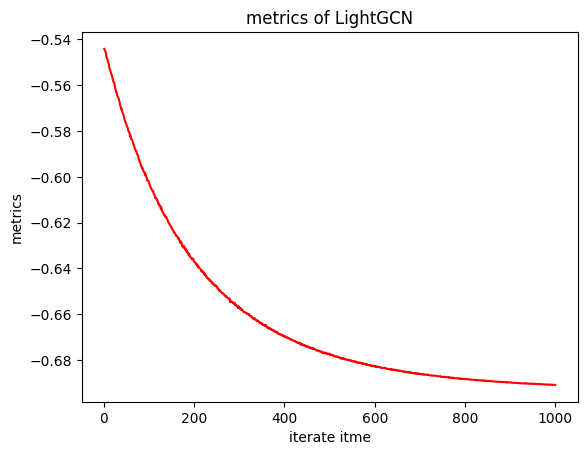

In [44]:
fig, ax = plt.subplots()
plt.plot(epoch_list, loss_list, color='r',label="loss")
"""plt.plot(epoch_list, rec_list, color='g', label="recall@20")
plt.plot(epoch_list, ndcg_list, color='blue', label="ndcg@20")
plt.legend()"""
plt.xlabel("iterate itme")
plt.ylabel('metrics')
plt.title('metrics of LightGCN')

In [45]:
print(len(rec_list))

10
